<a href="https://colab.research.google.com/github/frogi16/MLP-learning-visualiser/blob/main/MLPVisualClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualisation functions from previous notebook

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import colors

In [2]:
def create_grid_for_visualisation(vmin = -1, vmax = 1):
  fig = plt.figure(frameon=False, dpi=150)
  grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.3, cbar_mode="single", cbar_location="right")
  cbar = plt.cm.ScalarMappable(cmap='bwr', norm=colors.Normalize(vmin=vmin, vmax=vmax))
  fig.colorbar(cbar, cax=grid.cbar_axes[0], orientation="vertical")
  return fig, grid

def plot_weigths_and_biases(grid, iteration, n_layer, coefs, biases):
  return [grid[0].imshow(coefs[iteration - 1][n_layer - 1], cmap='bwr', origin='lower'),
          grid[1].imshow([biases[iteration - 1][n_layer - 1]], cmap='bwr', origin='lower')]

def set_title_after_every_iteration(grid, n_layer, iteration):
  grid[0].set_title(f"Wagi połączeń, warstwa {n_layer}\n" + f"iteracja {iteration}")

def describe_axes_and_labels(grid, iteration, n_layer):
  set_title_after_every_iteration(grid, n_layer, iteration)
  grid[1].set_xlabel('Neuron wyjściowy')
  grid[0].set_ylabel('Neuron wejściowy')

  grid[1].set_title('Biasy', fontsize=10)
  grid[1].yaxis.set_visible(False) 

In [3]:
def plot_layer(iteration, n_layer, coefs, biases):
  fig, grid = create_grid_for_visualisation()
  describe_axes_and_labels(grid, iteration, n_layer)
  plot_weigths_and_biases(grid, iteration, n_layer, coefs, biases)
  fig.show()

In [4]:
from matplotlib import rc
rc('animation', html='jshtml')

import math
import numpy as np
from matplotlib import animation, colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def animate_layer_no(n_layer, coefs, biases, start = 1, end = None):
    if end is None:
      end = len(coefs)
    fig, grid = create_grid_for_visualisation()
    describe_axes_and_labels(grid, start, n_layer)

    def animate(i):
        i += 1
        print('\r', 'Frame ', i, end='')
        set_title_after_every_iteration(grid, n_layer, i)
        return plot_weigths_and_biases(grid, i, n_layer, coefs, biases)

    anim = animation.FuncAnimation(fig, animate, frames=len(coefs), interval=100, blit=True)
    return anim

# MLP Visual Classifier class

In [5]:
from sklearn.neural_network import MLPClassifier
import copy

class MLPVisualClassifier(MLPClassifier):
  def __init__(self, **kwargs):
    if kwargs.get("solver") == 'lbfgs':
      raise ValueError(f"lbfgs is not a stochastic solver and learning\
 iteration after iteration is not supported, so visualisation can't be created.\
 Use other solver or standard {self.__class__.__bases__[0].__name__}")
      
    self.save_scores = kwargs.get("save_scores")
    self.verbose = kwargs.get("verbose")

    #overwrite parameters later passed to MLPClassifier
    kwargs["warm_start"] = True

    #delete parameters not used by MLPClassifier
    del kwargs["save_scores"]

    super().__init__(**kwargs)

    self.biases = []
    self.coefs = []
    
    if self.save_scores:
      self.train_scores = []

  def partial_fit(self, x, y, classes = None, classes_from_unique = False):
    if classes_from_unique:
      classes = np.unique(y)

    super().partial_fit(x, y, classes)
    
    self.coefs.append(copy.deepcopy(self.coefs_))
    self.biases.append(copy.deepcopy(self.intercepts_))

    if self.save_scores:
      self.train_scores.append(self.score(x, y))

  def fit(self, x, y):
    self.partial_fit(x, y, classes_from_unique = True)
    while self._no_improvement_count <= self.n_iter_no_change:
      if self.n_iter_ == self.max_iter:
        if self.verbose:
          print(f"Maximum iterations {self.max_iter} reached and the optimization hasn't converged yet. Stopping")
        break

      self.partial_fit(x, y)
      
  def plot_transformation_layer(self, iteration, n_layer):
    if not (1 <= iteration <= self.n_iter_):
      raise ValueError(f"Iteration not in range [1, {self.n_iter_}]")
    
    if not (1 <= n_layer < self.n_layers_):
      raise ValueError(f"Layer not in range [1, {self.n_layers_-1}]")

    plot_layer(iteration, n_layer, self.coefs, self.biases)

  def animate_transformation_layer(self, n_layer, start = 1, end = None):
    if not (1 <= n_layer < self.n_layers_):
      raise ValueError(f"Layer not in range [1, {self.n_layers_}-1]")
    
    if end is None:
      end = len(self.coefs)
    
    return animate_layer_no(n_layer, self.coefs, self.biases, start, end)

  def print_layer_shapes(self):
    print("biases")
    print("size:\t", len(self.biases[0]))
    for i in range(len(self.coefs[0])):
      print("\tsize:\t", len(self.coefs[0][i]))
    print()
    print("coefs")
    print("size:\t", len(self.coefs[0]))
    for i in range(len(self.coefs[0])):
      print("\tsize:\t", len(self.coefs[0][i]), "x", len(self.coefs[0][i][0]))


# Use for classifying red wine dataset

In [6]:
from sklearn.model_selection import train_test_split
import copy
import numpy as np
import pandas as pd
import math
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

In [7]:
#columns:
#    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
#    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
#    "pH", "sulphates", "alcohol", "quality"

data = pd.read_csv (r'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

y = pd.DataFrame(data, columns= ['quality']).values.ravel()
X = pd.DataFrame(data)
X = X.drop(columns='quality')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Iteration 1, loss = 1.43405388
Iteration 2, loss = 1.07022508
Iteration 3, loss = 0.99383297
Iteration 4, loss = 0.96133336
Iteration 5, loss = 0.93553752
Iteration 6, loss = 0.91614944
Iteration 7, loss = 0.90055304
Iteration 8, loss = 0.88658609
Iteration 9, loss = 0.87304511
Iteration 10, loss = 0.86055759
Iteration 11, loss = 0.84817377
Iteration 12, loss = 0.83708970
Iteration 13, loss = 0.82681032
Iteration 14, loss = 0.81608339
Iteration 15, loss = 0.80496767
Iteration 16, loss = 0.79396043
Iteration 17, loss = 0.78199887
Iteration 18, loss = 0.76994225
Iteration 19, loss = 0.75657940
Iteration 20, loss = 0.74356566
Iteration 21, loss = 0.73005189
Iteration 22, loss = 0.71665082
Iteration 23, loss = 0.70236324
Iteration 24, loss = 0.68897611
Iteration 25, loss = 0.67576272
Iteration 26, loss = 0.66268584
Iteration 27, loss = 0.65137687
Iteration 28, loss = 0.63852807
Iteration 29, loss = 0.62920502
Iteration 30, loss = 0.61705910
Iteration 31, loss = 0.60216998
Iteration 32, los

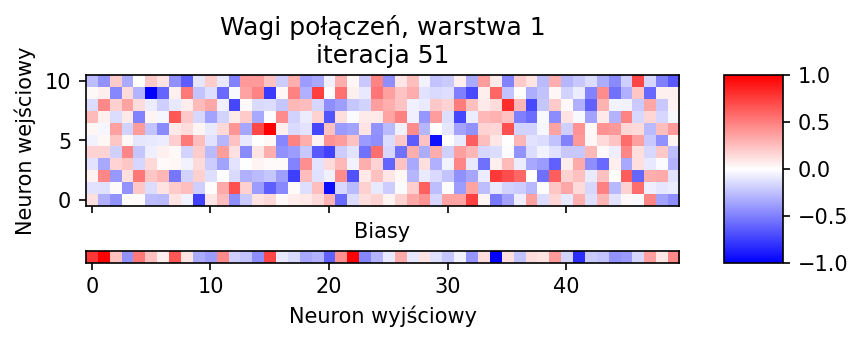

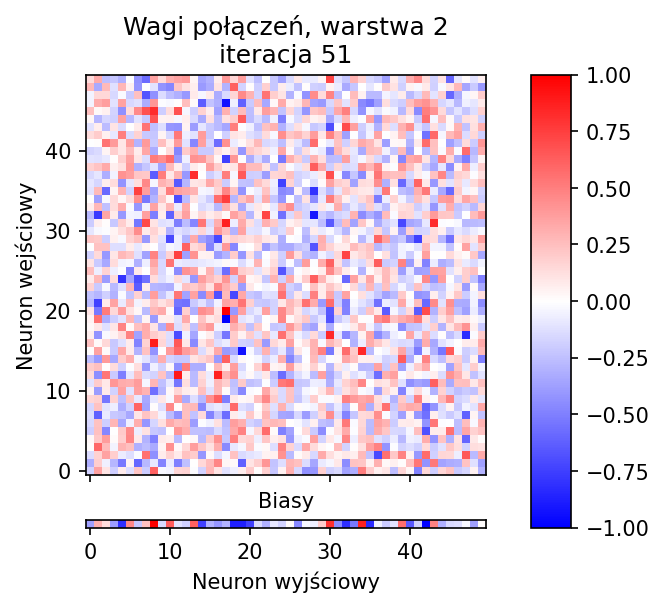

In [11]:
mlp = MLPVisualClassifier(save_scores = True, hidden_layer_sizes=(50, 50), max_iter=50, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=10,
                    learning_rate_init=.14, n_iter_no_change = 5, warm_start = False)

mlp.fit(X_train, y_train)
mlp.partial_fit(X_train, y_train)

mlp.plot_transformation_layer(iteration = mlp.n_iter_, n_layer = 1)
anim = mlp.animate_transformation_layer(2)
anim